In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import RMSprop, Adam

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow_datasets as tfds

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

4 Physical GPUs, 1 Logical GPU


# Data Pipeline

In [2]:
BATCH_SIZE = 8
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_HEIGHT = IMG_WIDTH = 256
dataset_name = 'vangogh2photo'

train_style, test_style = tfds.load(f'cycle_gan/{dataset_name}', split=['trainA', 'testA'], as_supervised=True)
train_content, test_content = tfds.load('celeb_a', split=['train', 'test'], with_info=False)

def preprocess_content(sample):
    image = sample['image']
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image = tf.cast(image, tf.float32)
    return image

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])
    image = tf.cast(image, tf.float32)
    return image

train_style = train_style.map(
    preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

train_content = train_content.map(
    preprocess_content, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

test_style = test_style.map(
    preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_content = test_content.map(
    preprocess_content, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()

train_dataset = tf.data.Dataset.zip((train_content, train_style))
test_dataset = tf.data.Dataset.zip((test_content, test_style))

# Custom Layers

In [ ]:
class AdaIN(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(AdaIN, self).__init__()
        self.epsilon = epsilon
        
    def call(self, inputs):
        x = inputs[0] # content
        y = inputs[1] # style
        mean_x, var_x = tf.nn.moments(x, axes=(1,2), keepdims=True)
        mean_y, var_y = tf.nn.moments(y, axes=(1,2), keepdims=True)
        std_x = tf.sqrt(var_x+self.epsilon)
        std_y = tf.sqrt(var_y+self.epsilon)
        output = std_y*(x - mean_x)/(std_x) + mean_y
        
        return output
    

class Conv2D(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel=3, use_relu=True):
        super(Conv2D, self).__init__()
        self.kernel = kernel
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_relu = use_relu
        
    def build(self, input_shape):

        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer='glorot_normal',
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
    @tf.function
    def call(self, inputs):
        padded = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        # perform conv2d using low level API
        output = tf.nn.conv2d(padded, self.w, strides=1, padding="VALID") + self.b
        if self.use_relu:
            output = tf.nn.relu(output)
        return output
    

# Arbitrary Style Transfer

In [93]:
class ArbitraryStyleTransfer():
    def __init__(self, image_shape, load_path = ''):

        self.image_shape = image_shape
        content_image_input = layers.Input(shape=image_shape, name='content_image')
        style_image_input = layers.Input(shape=image_shape, name='style_image')

        
        self.encoder = self.build_encoder(name='encoder')
        self.decoder = self.build_decoder()
        
        '''
        Style Transfer Network
        '''
        content_image = self.preprocess(content_image_input)
        style_image = self.preprocess(style_image_input)
        
        self.content_target = self.encoder(content_image)
        self.style_target = self.encoder(style_image)

        adain_output = AdaIN()([self.content_target[-1], self.style_target[-1]])
            
        self.stylized_image = self.postprocess(self.decoder(adain_output))
        
        self.stn = Model([content_image_input, style_image_input], self.stylized_image)
        
        '''
        Training Network
        '''
        output_features = self.encoder(self.preprocess(self.stylized_image))

        self.training_model = Model([content_image_input, style_image_input],
                                    [adain_output, output_features, self.style_target])
        
        initial_lr = 1e-4
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_lr, decay_steps=200, decay_rate=0.96, staircase=True
        )

        self.optimizer = Adam(learning_rate=lr_schedule)
        checkpoint_path = f"./checkpoints/arbitrary"
        self.ckpt = tf.train.Checkpoint(decoder = self.decoder)
        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, checkpoint_path, max_to_keep=40)
        if load_path:
            self.load_checkpoint(load_path)
    
    def load_checkpoint(self, ckpt_path):
        self.ckpt.restore(ckpt_path)
        
    def preprocess(self, image):
        # rgb to bgr
        image = tf.reverse(image, axis=[-1])

        return tf.keras.applications.vgg19.preprocess_input(image)

    def postprocess(self, image):

        return tf.clip_by_value(image, 0., 255.)
    
    def build_encoder(self, name='encoder'):
        self.encoder_layers = ['block1_conv1',
                               'block2_conv1',
                               'block3_conv1', 
                               'block4_conv1']
        
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

        layer_outputs = [vgg.get_layer(x).output for x in self.encoder_layers]
    
        return Model(vgg.input, layer_outputs, name=name)
        
    
    def build_decoder(self):
        
        block = tf.keras.Sequential([\
                Conv2D(512, 256, 3),
                UpSampling2D((2,2)),
                Conv2D(256, 256, 3),
                Conv2D(256, 256, 3),
                Conv2D(256, 256, 3),
                Conv2D(256, 128, 3),
                UpSampling2D((2,2)),
                Conv2D(128, 128, 3),
                Conv2D(128, 64, 3),
                UpSampling2D((2,2)),
                Conv2D(64, 64, 3),
                Conv2D(64, 3, 3, use_relu=False)],
                                   name='decoder')
        return block
    
    def calc_style_loss(self, y_true, y_pred):
        n_features = len(y_true)
        epsilon = 1e-5
        loss = []

        for i in range(n_features):
            mean_true, var_true = tf.nn.moments(y_true[i], axes=(1,2), keepdims=True)
            mean_pred, var_pred = tf.nn.moments(y_pred[i], axes=(1,2), keepdims=True)
            std_true, std_pred = tf.sqrt(var_true+epsilon), tf.sqrt(var_pred+epsilon)
            mean_loss = tf.reduce_sum(tf.square(mean_true-mean_pred))
            std_loss = tf.reduce_sum(tf.square(std_true-std_pred))
            loss.append(mean_loss + std_loss)
            
        return tf.reduce_mean(loss)


    @tf.function
    def train_step(self, train_data):
        with tf.GradientTape() as tape:
            adain_output, output_features, style_target = self.training_model(train_data)

            content_loss = tf.reduce_sum((output_features[-1]-adain_output)**2)
            style_loss = self.style_weight * self.calc_style_loss(style_target, output_features)
            loss =  content_loss + style_loss

            gradients = tape.gradient(loss, self.decoder.trainable_variables)

            self.optimizer.apply_gradients(zip(gradients, self.decoder.trainable_variables))

        return content_loss, style_loss
    
    def train(self, train_generator, test_generator, steps, interval=100, style_weight=1e4):
        
        self.style_weight = style_weight

        for i in range(steps):
            train_data = next(train_generator)
            content_loss, style_loss = self.train_step(train_data)

            if i%interval == 0:
                ckpt_save_path = self.ckpt_manager.save()
                print ('Saving checkpoint for step {} at {}'.format(i, ckpt_save_path))
                print(f"Content_loss {content_loss:.4f}, style_loss {style_loss:.4f}")
                val_data = next(test_generator)
                self.stylized_images = self.stn(val_data)
                self.plot_images(val_data[0], val_data[1], self.stylized_images)

    
    def plot_images(self, contents, styles, stylized):
        grid_row = min(contents.shape[0], 1)
        grid_col = 3
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*6, grid_row*6))

        for row in range(grid_row):
            
            ax = axarr if grid_row==1 else axarr[row]
            
            ax[0].imshow(styles[row]/255.)
            ax[0].axis('off')
            ax[1].imshow(contents[row]/255.)
            ax[1].axis('off')
            ax[2].imshow(stylized[row]/255.)
            ax[2].axis('off') 

        plt.show()
        
model = ArbitraryStyleTransfer((IMG_WIDTH, IMG_HEIGHT,3))

In [ ]:
model.train(iter(train_dataset), iter(test_dataset), 
            style_weight=1e5, steps=10000, interval=10)

In [83]:
#model.decoder.load_checkpoint('./checkpoints/arbitrary/ckpt-100')
test_data_itor = iter(test_dataset)

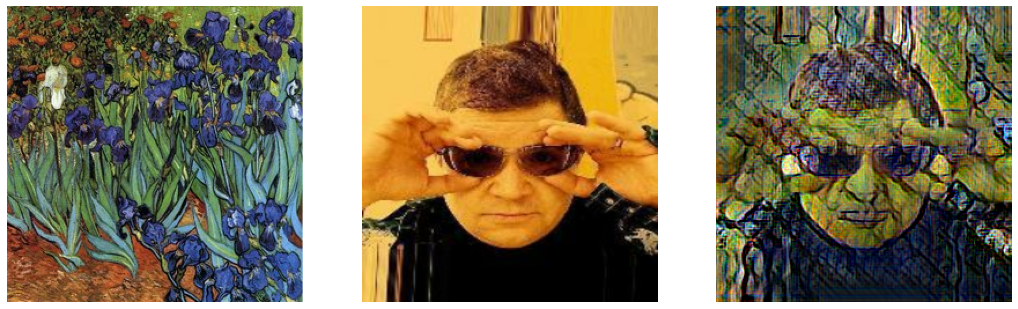

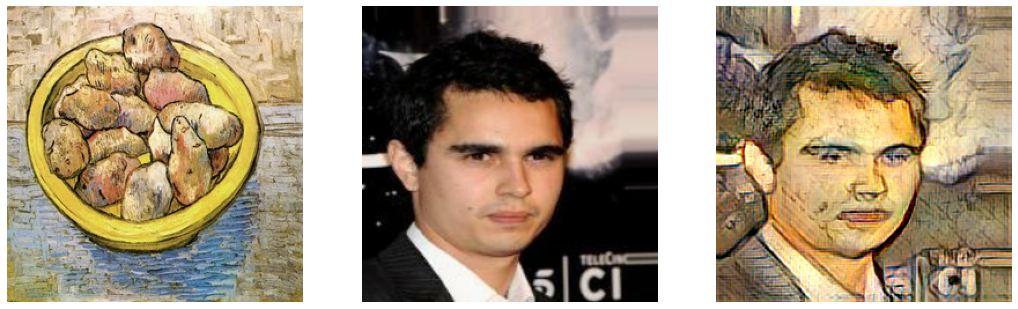

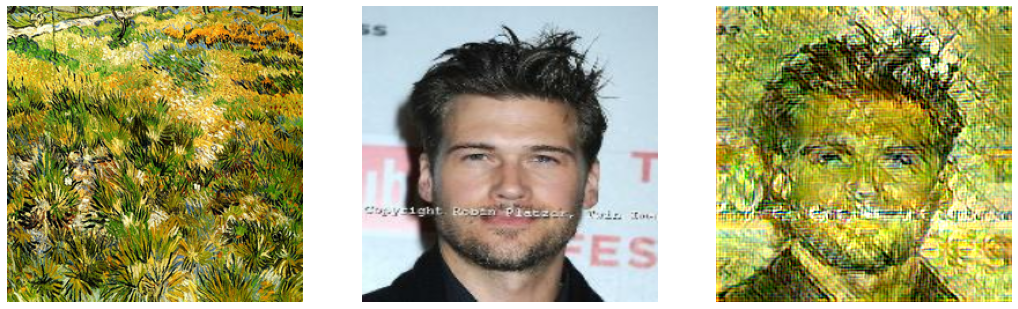

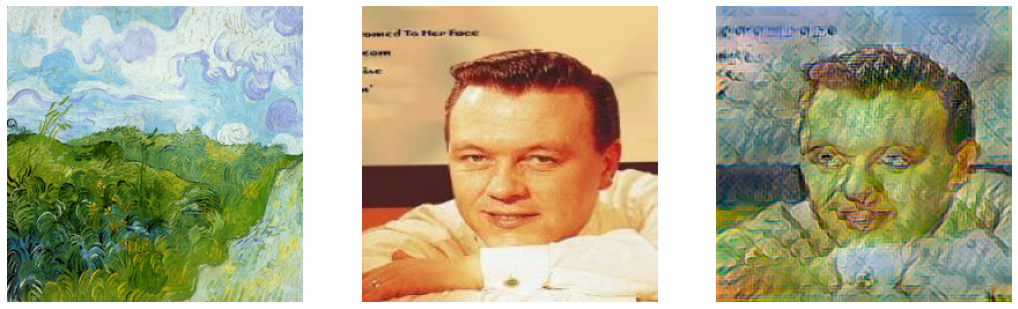

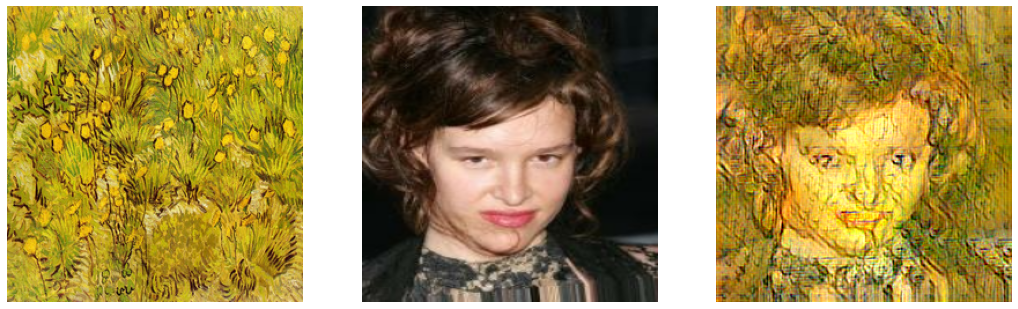

In [92]:
for i in range(5):
    val_data = next(test_data_itor)
    stylized_images = model.stn(val_data)
    model.plot_images(val_data[0], val_data[1], stylized_images)